# Importing Relevant Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd

# Loading Data

In [2]:
combined_df = pd.read_csv("gold_data/Combined.csv")
gold_futures_df = pd.read_csv("gold_data/Gold Futures Historical Data.csv")
gold_dataset_news = pd.read_csv("gold_data/gold_dataset_news.csv")
vix = pd.read_csv("gold_data/VIX_History.csv")
sp500 = pd.read_csv("gold_data/sp500.csv")

In [3]:
vix.shape

(8907, 5)

# Setting all datasets for same date range

In [4]:
# Step 1 — Strip spaces and convert safely
gold_dataset_news["Dates"] = gold_dataset_news["Dates"].astype(str).str.strip()

# Step 2 — Try parsing with dayfirst=True and coerce errors
gold_dataset_news["Dates"] = pd.to_datetime(
    gold_dataset_news["Dates"], dayfirst=True, errors="coerce"
)

# Step 3 — Store all rows with invalid dates in a new DataFrame
invalid = gold_dataset_news[gold_dataset_news["Dates"].isna()]

# Step 4 — Drop invalid rows from main dataset
gold_dataset_news = gold_dataset_news.dropna(subset=["Dates"])

# Step 5 — Extract min and max date
min_date = gold_dataset_news["Dates"].min()
max_date = gold_dataset_news["Dates"].max()

print(f"✅ Cleaned date range: {min_date.date()} to {max_date.date()}")

✅ Cleaned date range: 2000-02-15 to 2019-02-01


In [5]:
import pandas as pd

# --- Define common date range ---
start_date = pd.to_datetime("2000-02-15")
end_date = pd.to_datetime("2019-02-01")

# --- For VIX ---
# ✅ FIX: Let pandas infer date format (VIX appears to be YYYY-MM-DD)
vix["DATE"] = pd.to_datetime(vix["DATE"], errors="coerce")
# Drop bad rows explicitly
vix = vix.dropna(subset=["DATE"])
# Filter to date range
vix = vix[(vix["DATE"] >= start_date) & (vix["DATE"] <= end_date)]

# --- For Gold Futures ---
gold_futures_df["Date"] = pd.to_datetime(gold_futures_df["Date"], errors="coerce")
gold_futures_df = gold_futures_df.dropna(subset=["Date"])
gold_futures_df = gold_futures_df[
    (gold_futures_df["Date"] >= start_date) & (gold_futures_df["Date"] <= end_date)
]

# --- For S&P 500 ---
sp500["Date"] = pd.to_datetime(sp500["Date"], errors="coerce")
sp500 = sp500.dropna(subset=["Date"])
sp500 = sp500[(sp500["Date"] >= start_date) & (sp500["Date"] <= end_date)]

# --- Check final results ---
print(f"✅ vix date range: {vix['DATE'].min().date()} to {vix['DATE'].max().date()}")
print(
    f"✅ gold_futures_df date range: {gold_futures_df['Date'].min().date()} to {gold_futures_df['Date'].max().date()}"
)
print(
    f"✅ sp500 date range: {sp500['Date'].min().date()} to {sp500['Date'].max().date()}"
)

print(f"\nvix.shape: {vix.shape}")
print(f"gold_futures_df.shape: {gold_futures_df.shape}")
print(f"sp500.shape: {sp500.shape}")

✅ vix date range: 2000-02-15 to 2019-02-01
✅ gold_futures_df date range: 2000-02-15 to 2019-02-01
✅ sp500 date range: 2000-02-15 to 2019-02-01

vix.shape: (4772, 5)
gold_futures_df.shape: (4781, 7)
sp500.shape: (4771, 7)


In [6]:
# Step 1 — Get common dates across all three datasets
common_dates = set(vix["DATE"]) & set(gold_futures_df["Date"]) & set(sp500["Date"])

# Step 2 — Convert to sorted list
common_dates = sorted(list(common_dates))

# Step 3 — Subset each DataFrame to only keep rows with those common dates
vix = vix[vix["DATE"].isin(common_dates)].reset_index(drop=True)
gold_futures_df = gold_futures_df[
    gold_futures_df["Date"].isin(common_dates)
].reset_index(drop=True)
sp500 = sp500[sp500["Date"].isin(common_dates)].reset_index(drop=True)

# Step 4 — (Optional) Rename 'Date' in gold and sp500 to 'DATE' for consistency
gold_futures_df = gold_futures_df.rename(columns={"Date": "DATE"})
sp500 = sp500.rename(columns={"Date": "DATE"})

# Final check
print(f"✅ Final vix shape: {vix.shape}")
print(f"✅ Final gold_futures_df shape: {gold_futures_df.shape}")
print(f"✅ Final sp500 shape: {sp500.shape}")
print(f"✅ All datasets now share {len(common_dates)} consistent trading days.")

✅ Final vix shape: (4708, 5)
✅ Final gold_futures_df shape: (4708, 7)
✅ Final sp500 shape: (4708, 7)
✅ All datasets now share 4708 consistent trading days.


# Generating % CHange for Indexes and Gold Price Data

In [7]:
# Ensure DATE is datetime (already confirmed but good practice)
vix["DATE"] = pd.to_datetime(vix["DATE"])

# Calculate percent change in closing price
vix["Daily_Pct_Change"] = vix["CLOSE"].pct_change() * 100

# Optional: round for better readability
vix["Daily_Pct_Change"] = vix["Daily_Pct_Change"].round(2)

In [8]:
# Step 1 — Rename columns (must happen before we use 'CLOSE')
gold_futures_df = gold_futures_df.rename(columns={"Date": "DATE", "Price": "CLOSE"})

# Step 2 — Clean the 'CLOSE' column (remove commas, convert to float)
gold_futures_df["CLOSE"] = gold_futures_df["CLOSE"].astype(str).str.replace(",", "")
gold_futures_df["CLOSE"] = pd.to_numeric(gold_futures_df["CLOSE"], errors="coerce")

# Step 3 — Ensure DATE is datetime
gold_futures_df["DATE"] = pd.to_datetime(gold_futures_df["DATE"])

# Step 4 — Calculate daily percent change
gold_futures_df["Daily_Pct_Change"] = gold_futures_df["CLOSE"].pct_change() * 100
gold_futures_df["Daily_Pct_Change"] = gold_futures_df["Daily_Pct_Change"].round(2)

In [ ]:
# Step 1 — Rename columns for consistency
sp500 = sp500.rename(columns={"Date": "DATE", "Adj Close": "CLOSE"})

# Step 2 — Ensure DATE is datetime (already confirmed in your case)
sp500["DATE"] = pd.to_datetime(sp500["DATE"])

# Step 3 — Calculate daily percent change from adjusted close
sp500["Daily_Pct_Change"] = sp500["CLOSE"].pct_change() * 100
sp500["Daily_Pct_Change"] = sp500["Daily_Pct_Change"].round(2)

# Optional: Preview
print(sp500[["DATE", "CLOSE", "Daily_Pct_Change"]].head())

        DATE        CLOSE  Daily_Pct_Change
0 2000-02-15  1402.050049               NaN
1 2000-02-16  1387.670044             -1.03
2 2000-02-17  1388.260010              0.04
3 2000-02-18  1346.089966             -3.04
4 2000-02-22  1352.170044              0.45


In [ ]:
dates = pd.DataFrame(
    {"DATE": pd.date_range(start="2000-01-01", end="2020-01-01", freq="D")}
)

# Get min and max in dates
min_date = dates["DATE"].min()
max_date = dates["DATE"].max()
print(f"The date range is from {min_date.date()} to {max_date.date()}")

The date range is from 2000-01-01 to 2020-01-01


# Merging Data and Assessing Columns and Dimensions

In [36]:
# Step 1 — Create the daily calendar
dates = pd.DataFrame(
    {"DATE": pd.date_range(start="2000-01-01", end="2020-01-01", freq="D")}
)

# Step 2 — Ensure all datasets have consistent 'DATE' column names
# Already done: vix['DATE'], gold_futures_df['DATE'], sp500['DATE']

# Step 3 — Apply prefixes to all columns (except DATE)
vix_renamed = vix.rename(columns=lambda col: f"vix_{col}" if col != "DATE" else "DATE")
gold_renamed = gold_futures_df.rename(
    columns=lambda col: f"gold_{col}" if col != "DATE" else "DATE"
)
sp500_renamed = sp500.rename(
    columns=lambda col: f"sp500_{col}" if col != "DATE" else "DATE"
)

# Step 4 — Merge all datasets onto the full dates range
merged_df = dates.merge(sp500_renamed, on="DATE", how="left")
merged_df = merged_df.merge(vix_renamed, on="DATE", how="left")
merged_df = merged_df.merge(gold_renamed, on="DATE", how="left")

# Get all column names
for column in merged_df.columns:
    print(f"{column}")

merged_df.shape

DATE
sp500_Open
sp500_High
sp500_Low
sp500_Close
sp500_CLOSE
sp500_Volume
sp500_Daily_Pct_Change
vix_OPEN
vix_HIGH
vix_LOW
vix_CLOSE
vix_Daily_Pct_Change
gold_CLOSE
gold_Open
gold_High
gold_Low
gold_Vol.
gold_Change %
gold_Daily_Pct_Change


(7306, 20)

In [ ]:
# Step 1 — Define key columns for validation
key_columns = ["sp500_CLOSE", "vix_CLOSE", "gold_CLOSE"]

# Step 2 — Drop any rows with NaNs in key columns
merged_clean = merged_df.dropna(subset=key_columns).reset_index(drop=True)


print(f"✅ Cleaned merged dataset shape: {merged_clean.shape}")

✅ Cleaned merged dataset shape: (4708, 20)


In [ ]:
# Remove first row of merged_clean
merged_clean = merged_clean.iloc[1:].reset_index(drop=True)

,DATE,sp500_Open,sp500_High,sp500_Low,sp500_Close,sp500_CLOSE,sp500_Volume,sp500_Daily_Pct_Change,vix_OPEN,vix_HIGH,vix_LOW,vix_CLOSE,vix_Daily_Pct_Change,gold_CLOSE,gold_Open,gold_High,gold_Low,gold_Vol.,gold_Change %,gold_Daily_Pct_Change
0,2000-02-16,1402.050049,1404.550049,1385.579956,1387.670044,1387.670044,1.018800e+09,-1.03,23.2,23.83,22.74,23.51,2.57,305.0,304.20,306.00,299.70,56.34K,0.30%,0.39


# Data Modeling on News Dataset

In [16]:
gold_dataset_news.head()
gold_dataset_news.shape

(10405, 10)

# FInbert for Sentiment Score

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

In [19]:
from tqdm import tqdm

In [20]:
# Initialize tqdm for pandas
tqdm.pandas()

# Load FinBERT model and tokenizer
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


# Define sentiment function
def analyze_sentiment(text):
    if pd.isna(text) or str(text).strip() == "":
        return {"label": "neutral", "score": 0.0}
    result = finbert(str(text))[0]
    return result


# Apply sentiment with progress bar
sentiment_results = gold_dataset_news["News"].progress_apply(analyze_sentiment)

# Extract results
gold_dataset_news["finbert_sentiment_label"] = sentiment_results.apply(
    lambda x: x["label"]
)
gold_dataset_news["finbert_score"] = sentiment_results.apply(
    lambda x: round(x["score"], 4)
)

# Preview
print(gold_dataset_news[["News", "finbert_sentiment_label", "finbert_score"]].head())

Device set to use cpu
100%|██████████| 10405/10405 [13:44<00:00, 12.62it/s]

                                                News finbert_sentiment_label  \
0  april gold down 20 cents to settle at $1,116.1...                negative   
1          gold suffers third straight daily decline                negative   
2     Gold futures edge up after two-session decline                positive   
3  dent research : is gold's day in the sun comin...                 neutral   
4  Gold snaps three-day rally as Trump, lawmakers...                positive   

   finbert_score  
0         0.9469  
1         0.9320  
2         0.8591  
3         0.9147  
4         0.4886  


In [21]:
for column in gold_dataset_news.columns:
    print(f"{column}")

Dates
URL
News
Price Direction Up
Price Direction Constant
Price Direction Down
Asset Comparision
Past Information
Future Information
Price Sentiment
finbert_sentiment_label
finbert_score


In [22]:
# Step 1 — Ensure 'Dates' is datetime
gold_dataset_news["Dates"] = pd.to_datetime(gold_dataset_news["Dates"])

# Step 2 — Group and aggregate (no weighting)
agg_df = (
    gold_dataset_news.groupby(gold_dataset_news["Dates"].dt.date)
    .agg(
        news_count=("News", "count"),
        positive_news_count=(
            "finbert_sentiment_label",
            lambda x: (x == "positive").sum(),
        ),
        negative_news_count=(
            "finbert_sentiment_label",
            lambda x: (x == "negative").sum(),
        ),
        neutral_news_count=(
            "finbert_sentiment_label",
            lambda x: (x == "neutral").sum(),
        ),
        avg_finbert_score=("finbert_score", "mean"),
    )
    .reset_index()
    .rename(columns={"Dates": "date"})
)


# Step 3 — Label based on average FinBERT score
def label_from_score(score):
    if score >= 0.66:
        return "positive"
    elif score >= 0.33:
        return "neutral"
    else:
        return "negative"


agg_df["daily_label"] = agg_df["avg_finbert_score"].apply(label_from_score)

# Preview
print(agg_df.head())

         date  news_count  positive_news_count  negative_news_count  \
0  2000-02-15           1                    0                    0   
1  2000-02-17           1                    0                    1   
2  2000-03-24           1                    0                    1   
3  2000-04-27           1                    1                    0   
4  2000-05-04           1                    0                    1   

   neutral_news_count  avg_finbert_score daily_label  
0                   1             0.5855     neutral  
1                   0             0.8265    positive  
2                   0             0.5316     neutral  
3                   0             0.3933     neutral  
4                   0             0.4077     neutral  


In [23]:
agg_df.shape

(3672, 7)

In [24]:
# Step 1 — Convert 'DATE' in merged_clean to date only (drop time)
merged_clean["DATE"] = pd.to_datetime(merged_clean["DATE"]).dt.date

# Step 2 — Ensure agg_df["date"] is also a datetime.date (already seems like it, but safe to enforce)
agg_df["date"] = pd.to_datetime(agg_df["date"]).dt.date

# Step 3 — Merge on date
final_merged = merged_clean.merge(
    agg_df, left_on="DATE", right_on="date", how="left", indicator=True
)

# Step 4 — Check for any rows that didn't match
final_merged["_merge"].value_counts()

# Step 4 — Optional cleanup
final_merged = final_merged.drop(
    columns=["date"]
)  # drop duplicate date column if desired
# Step 4 — Check for any rows that didn't match
final_merged["_merge"].value_counts()

_merge
both          3252
left_only     1455
right_only       0
Name: count, dtype: int64

In [25]:
final_merged.sample(20)

,DATE,sp500_Open,sp500_High,sp500_Low,sp500_Close,sp500_CLOSE,sp500_Volume,sp500_Daily_Pct_Change,vix_OPEN,vix_HIGH,...,gold_Vol.,gold_Change %,gold_Daily_Pct_Change,news_count,positive_news_count,negative_news_count,neutral_news_count,avg_finbert_score,daily_label,_merge
561,2002-05-21,1091.880005,1099.550049,1079.079956,1079.880005,1079.880005,1.200500e+09,-1.10,19.04,20.11,...,32.02K,0.03%,-0.69,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1125,2004-08-24,1095.680054,1100.939941,1092.819946,1096.189941,1096.189941,1.092500e+09,0.05,15.63,15.81,...,54.08K,-1.89%,-1.22,2.0,0.0,2.0,0.0,0.967850,positive,both
1299,2005-05-05,1175.650024,1178.619995,1166.770020,1172.630005,1172.630005,1.997100e+09,-0.26,13.48,15.82,...,35.69K,0.16%,0.89,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1572,2006-06-07,1263.609985,1272.469971,1255.770020,1256.150024,1256.150024,2.644170e+09,-0.61,15.83,17.86,...,51.07K,-0.33%,3.06,2.0,0.0,1.0,1.0,0.811550,positive,both
1498,2006-02-21,1287.239990,1291.920044,1281.329956,1283.030029,1283.030029,2.104320e+09,-0.33,12.36,12.64,...,42.09K,0.36%,0.00,3.0,2.0,0.0,1.0,0.810133,positive,both
398,2001-09-24,965.799988,1008.440002,965.799988,1003.450012,1003.450012,1.746600e+09,3.90,41.32,41.49,...,17.48K,-0.68%,-0.31,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3516,2014-04-15,1831.449951,1844.020020,1816.290039,1842.979980,1842.979980,3.736440e+09,0.68,16.14,17.50,...,188.99K,-2.05%,-0.25,4.0,1.0,3.0,0.0,0.839775,positive,both
4462,2018-02-12,2636.750000,2672.610107,2622.449951,2656.000000,2656.000000,4.055790e+09,1.39,27.25,29.70,...,0.75K,0.81%,-0.30,7.0,2.0,4.0,1.0,0.877429,positive,both
2948,2011-12-19,1219.739990,1224.569946,1202.369995,1205.349976,1205.349976,3.659820e+09,-1.17,25.14,25.38,...,121.28K,-0.08%,-1.29,5.0,1.0,3.0,1.0,0.857080,positive,both
4223,2017-03-02,2394.750000,2394.750000,2380.169922,2381.919922,2381.919922,3.821320e+09,-0.59,12.43,12.71,...,272.76K,-1.37%,0.52,9.0,1.0,7.0,1.0,0.922522,positive,both


In [ ]:
def resolve_daily_label(row):
    pos = row["positive_news_count"]
    neg = row["negative_news_count"]
    neu = row["neutral_news_count"]

    if pos > neg and pos > neu:
        return "positive"
    elif neg > pos and neg > neu:
        return "negative"
    elif neu > pos and neu > neg:
        return "neutral"
    elif pos == neg:
        return "neutral"
    elif neu == neg:
        return "negative"
    elif neu == pos:
        return "positive"
    else:
        return "neutral"  # fallback


# Apply logic
final_merged["daily_label"] = final_merged.apply(resolve_daily_label, axis=1)

# Exploration of Different Data Patterns

C:\Users\chris\AppData\Local\Temp\ipykernel_15152\1494334601.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_merged, x="daily_label", y="gold_Daily_Pct_Change", ax=axes[2], palette="coolwarm")


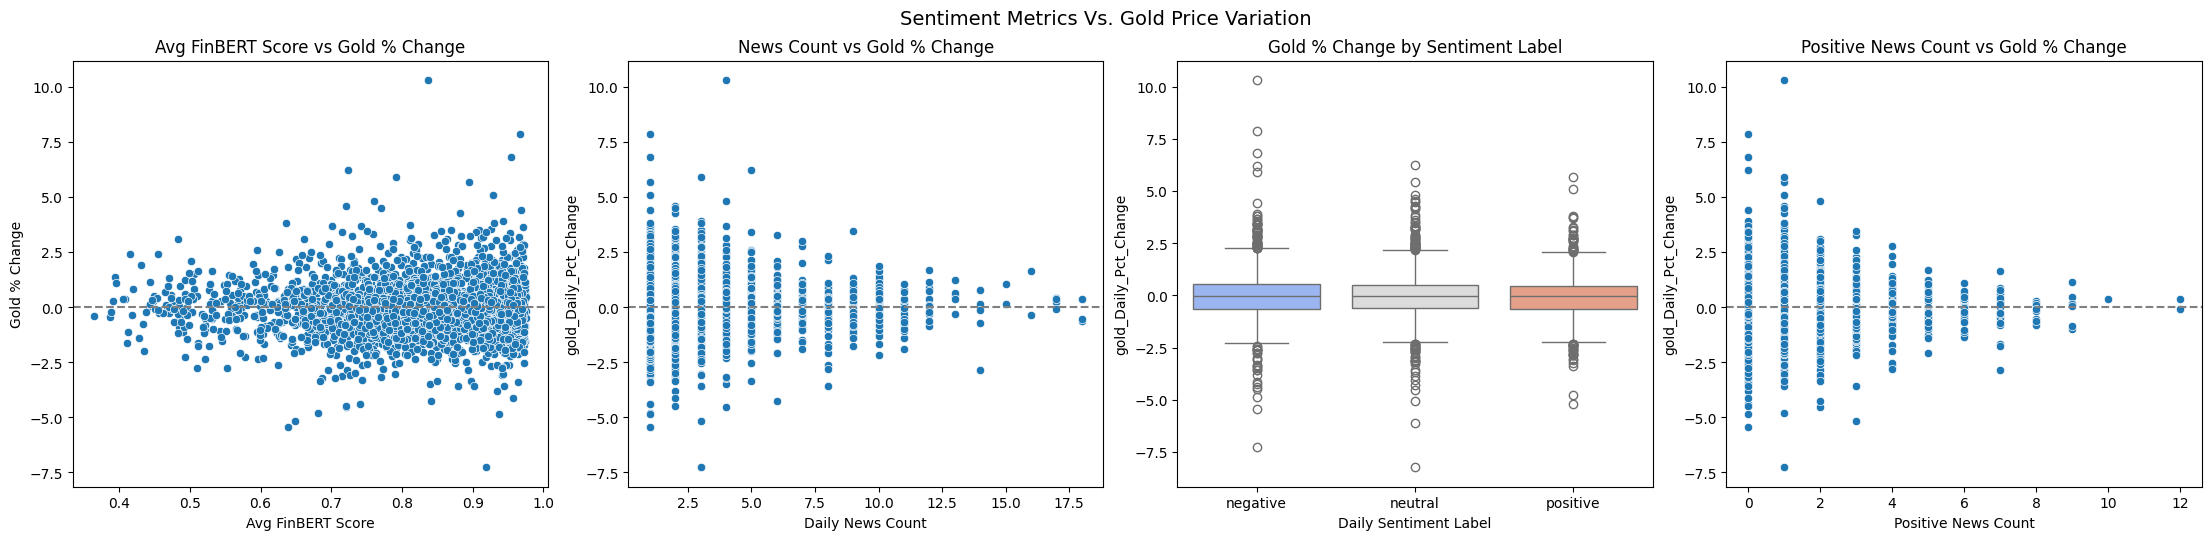

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'daily_label' to categorical order if not already
label_order = ["negative", "neutral", "positive"]
final_merged["daily_label"] = pd.Categorical(
    final_merged["daily_label"], categories=label_order, ordered=True
)

# Create 4 subplots side by side
fig, axes = plt.subplots(1, 4, figsize=(22, 5), constrained_layout=True)

# 1. avg_finbert_score vs gold_Daily_Pct_Change
sns.scatterplot(
    data=final_merged, x="avg_finbert_score", y="gold_Daily_Pct_Change", ax=axes[0]
)
axes[0].set_title("Avg FinBERT Score vs Gold % Change")
axes[0].axhline(0, linestyle="--", color="gray")
axes[0].set_xlabel("Avg FinBERT Score")
axes[0].set_ylabel("Gold % Change")

# 2. news_count vs gold_Daily_Pct_Change
sns.scatterplot(
    data=final_merged, x="news_count", y="gold_Daily_Pct_Change", ax=axes[1]
)
axes[1].set_title("News Count vs Gold % Change")
axes[1].axhline(0, linestyle="--", color="gray")
axes[1].set_xlabel("Daily News Count")

# 3. daily_label vs gold_Daily_Pct_Change (boxplot)
sns.boxplot(
    data=final_merged,
    x="daily_label",
    y="gold_Daily_Pct_Change",
    ax=axes[2],
    palette="coolwarm",
)
axes[2].set_title("Gold % Change by Sentiment Label")
axes[2].set_xlabel("Daily Sentiment Label")

# 4. positive_news_count vs gold_Daily_Pct_Change
sns.scatterplot(
    data=final_merged, x="positive_news_count", y="gold_Daily_Pct_Change", ax=axes[3]
)
axes[3].set_title("Positive News Count vs Gold % Change")
axes[3].axhline(0, linestyle="--", color="gray")
axes[3].set_xlabel("Positive News Count")

plt.suptitle("Sentiment Metrics Vs. Gold Price Variation", fontsize=14, y=1.05)
plt.show()

# Exploration of Gold Price Variation

📉 Bottom Quintile Threshold (20th percentile): -0.7900
📈 Top Quintile Threshold (80th percentile): 0.6600


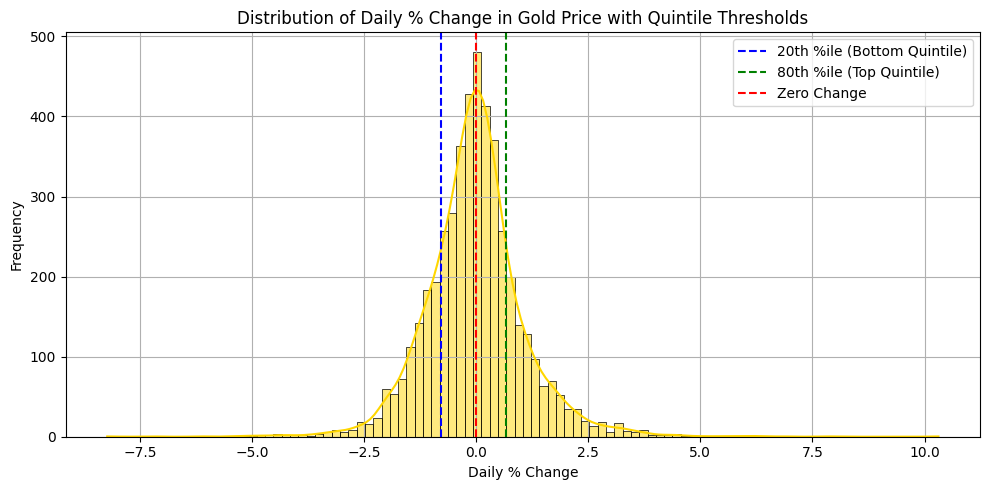

In [28]:
# Step 1 — Drop NaNs
gold_pct = final_merged["gold_Daily_Pct_Change"].dropna()

# Step 2 — Calculate quintile thresholds
bottom_quintile = gold_pct.quantile(0.2)
top_quintile = gold_pct.quantile(0.8)

print(f"📉 Bottom Quintile Threshold (20th percentile): {bottom_quintile:.4f}")
print(f"📈 Top Quintile Threshold (80th percentile): {top_quintile:.4f}")


# Step 3 — Create labels for each day
def label_quintile(change):
    if change <= bottom_quintile:
        return "Bottom Quintile"
    elif change >= top_quintile:
        return "Top Quintile"
    else:
        return "Middle 60%"


# Apply to your dataframe
final_merged["gold_quintile_label"] = final_merged["gold_Daily_Pct_Change"].apply(
    label_quintile
)

# Optional: Visualize
plt.figure(figsize=(10, 5))
sns.histplot(gold_pct, bins=100, kde=True, color="gold", edgecolor="black")
plt.axvline(
    bottom_quintile, color="blue", linestyle="--", label="20th %ile (Bottom Quintile)"
)
plt.axvline(
    top_quintile, color="green", linestyle="--", label="80th %ile (Top Quintile)"
)
plt.axvline(0, color="red", linestyle="--", label="Zero Change")
plt.title("Distribution of Daily % Change in Gold Price with Quintile Thresholds")
plt.xlabel("Daily % Change")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Which Features Matter Most

✅ Total training samples: 4706

✅ Classification Report:

              precision    recall  f1-score   support

      Bottom       0.11      0.03      0.05       128
      Middle       0.70      0.97      0.81       660
         Top       1.00      0.01      0.01       154

    accuracy                           0.68       942
   macro avg       0.61      0.33      0.29       942
weighted avg       0.67      0.68      0.58       942



C:\Users\chris\AppData\Local\Temp\ipykernel_15152\3131369561.py:70: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\miniforge3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


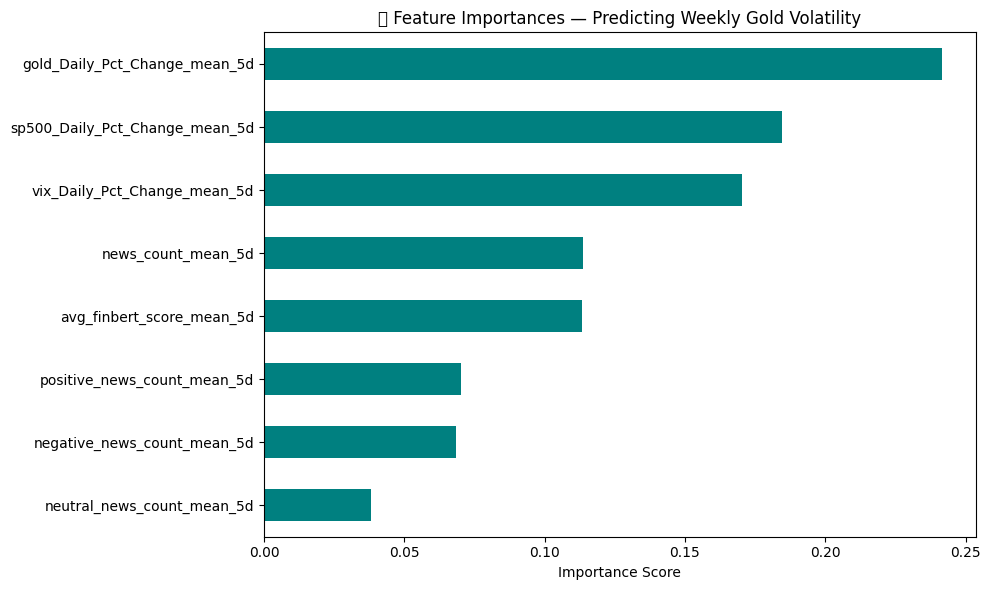

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1 — Ensure datetime and weekly label
final_merged["DATE"] = pd.to_datetime(final_merged["DATE"])
final_merged["week"] = final_merged["DATE"].dt.to_period("W-FRI").dt.end_time

# Step 2 — Filter only rows with known quintile labels
weekly_labeled = final_merged.dropna(subset=["gold_quintile_label"]).copy()

# Step 3 — Select features (only those with <------ tag)
features = [
    "sp500_Daily_Pct_Change",
    "vix_Daily_Pct_Change",
    "gold_Daily_Pct_Change",
    "news_count",
    "positive_news_count",
    "negative_news_count",
    "neutral_news_count",
    "avg_finbert_score",
]

# Step 4 — Fill sentiment-related NaNs
sentiment_cols = [
    "news_count",
    "positive_news_count",
    "negative_news_count",
    "neutral_news_count",
]
weekly_labeled[sentiment_cols] = weekly_labeled[sentiment_cols].fillna(0)
weekly_labeled["avg_finbert_score"] = weekly_labeled["avg_finbert_score"].fillna(
    weekly_labeled["avg_finbert_score"].median()
)

# Step 5 — Create 5-day rolling averages (lagged features)
for col in features:
    weekly_labeled[f"{col}_mean_5d"] = (
        weekly_labeled[col].rolling(window=5, min_periods=1).mean().shift(1)
    )

# Step 6 — Drop rows with any NaNs in features or label
X_cols = [f"{col}_mean_5d" for col in features]
weekly_labeled = weekly_labeled.dropna(subset=X_cols + ["gold_quintile_label"])

# Step 7 — Build feature matrix and encode target
X = weekly_labeled[X_cols]
y = weekly_labeled["gold_quintile_label"].map(
    {"Bottom Quintile": 0, "Middle 60%": 1, "Top Quintile": 2}
)

print(f"✅ Total training samples: {len(X)}")
if len(X) < 10:
    raise ValueError(
        "❌ Not enough data after filtering — please review input data or adjust window."
    )

# Step 8 — Train/test split (time-ordered)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 9 — Train model
clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Step 10 — Evaluate
y_pred = clf.predict(X_test)
print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Bottom", "Middle", "Top"]))

# Step 11 — Feature importance
importances = pd.Series(clf.feature_importances_, index=X_cols).sort_values(
    ascending=True
)
plt.figure(figsize=(10, 6))
importances.plot(kind="barh", color="teal")
plt.title("🔍 Feature Importances — Predicting Weekly Gold Volatility")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Test on Daily Variation

C:\Users\chris\AppData\Local\Temp\ipykernel_15152\555901850.py:37: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chris\miniforge3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


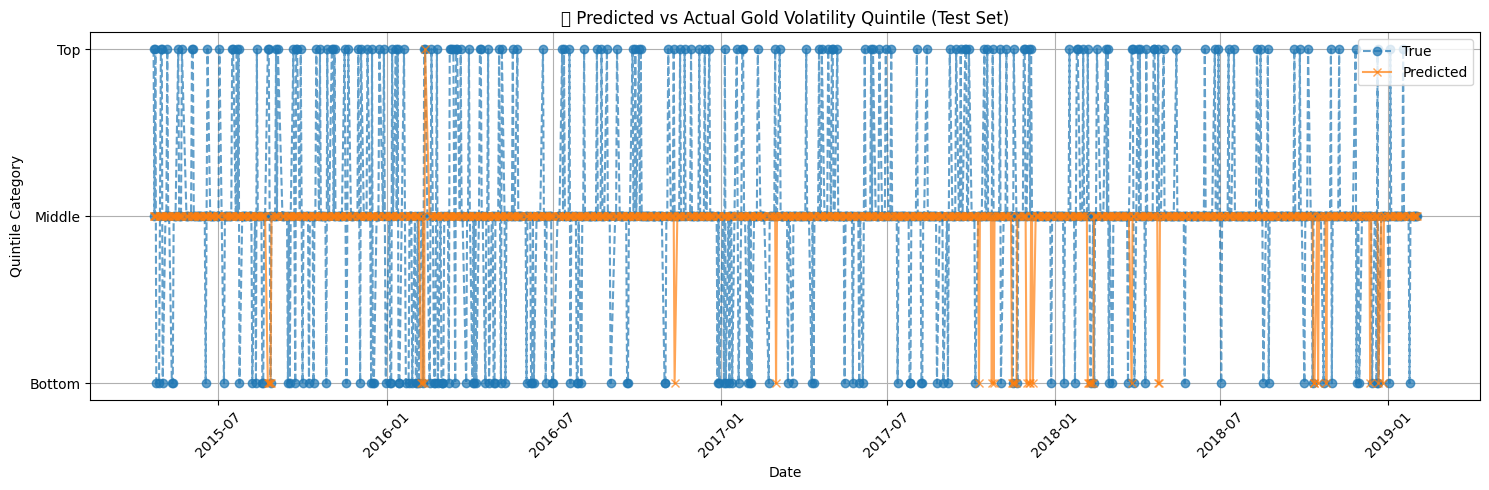

In [ ]:
# Step 12 — Reset index before train/test to keep track of rows
weekly_labeled_reset = weekly_labeled.reset_index(drop=True)
X = weekly_labeled_reset[X_cols]
y = weekly_labeled_reset["gold_quintile_label"].map(
    {"Bottom Quintile": 0, "Middle 60%": 1, "Top Quintile": 2}
)

# Split while keeping original row positions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Get the matching date values
test_dates = weekly_labeled_reset.loc[X_test.index, "DATE"]

# Step 13 — Build results dataframe
results_df = pd.DataFrame(
    {"DATE": test_dates.values, "True Label": y_test.values, "Predicted Label": y_pred}
).sort_values("DATE")

# ✅ Ensure DATE column is datetime
results_df["DATE"] = pd.to_datetime(results_df["DATE"])

# Step 14 — Plot with numeric labels
plt.figure(figsize=(15, 5))
plt.plot(
    results_df["DATE"],
    results_df["True Label"],
    label="True",
    linestyle="--",
    marker="o",
    alpha=0.7,
)
plt.plot(
    results_df["DATE"],
    results_df["Predicted Label"],
    label="Predicted",
    linestyle="-",
    marker="x",
    alpha=0.7,
)
plt.title("🎯 Predicted vs Actual Gold Volatility Quintile (Test Set)")
plt.xlabel("Date")
plt.ylabel("Quintile Category")
plt.yticks([0, 1, 2], ["Bottom", "Middle", "Top"])
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Overall Accuracy: {accuracy:.4f}")

✅ Overall Accuracy: 0.6815


In [ ]:
X_cols = [f"{col}_mean_5d" for col in features]
X_cols
weekly_labeled_reset = weekly_labeled.reset_index(drop=True)
X = weekly_labeled_reset[X_cols]
y = weekly_labeled_reset["gold_quintile_label"].map(
    {"Bottom Quintile": 0, "Middle 60%": 1, "Top Quintile": 2}
)

# Run Different Models Considering Weekly Variation

Tuning Random Forest...
Tuning Gradient Boosting...
Tuning Logistic Regression...


c:\Users\chris\miniforge3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\chris\miniforge3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\chris\miniforge3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\chris\miniforge3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

Tuning XGBoost...


c:\Users\chris\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:38:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\chris\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:38:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\chris\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:38:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\chris\miniforge3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:38:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

Tuning QDA...


c:\Users\chris\miniforge3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\chris\miniforge3\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\chris\miniforge3\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\chris\miniforge3\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\chris\miniforge3\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


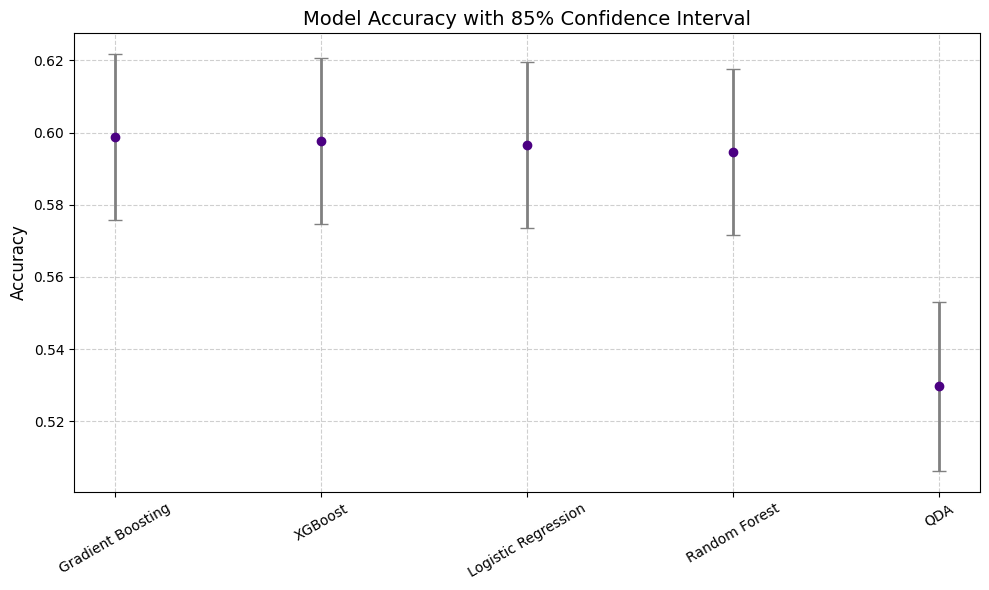

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from xgboost import XGBClassifier
from scipy.stats import norm
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)


# STEP 1 — Upsample Bottom & Top quintiles
def upsample_extremes(X_df, y_series, factor=2):
    df = X_df.copy()
    df["target"] = y_series.values
    bottom = df[df["target"] == 0]
    middle = df[df["target"] == 1]
    top = df[df["target"] == 2]

    bottom_upsampled = bottom.sample(
        n=len(bottom) * factor, replace=True, random_state=42
    )
    top_upsampled = top.sample(n=len(top) * factor, replace=True, random_state=42)

    upsampled = pd.concat([middle, bottom_upsampled, top_upsampled]).sample(
        frac=1, random_state=42
    )
    return upsampled.drop("target", axis=1), upsampled["target"]


# STEP 2 — Stratified split and upsample
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, y_train = upsample_extremes(
    pd.DataFrame(X_train, columns=X.columns), pd.Series(y_train), factor=2
)

param_grids = {
    "Random Forest": {
        "n_estimators": [100, 150, 200, 250, 300],
        "max_depth": [5, 10, 15, 20, None],
        "min_samples_split": [2, 3, 4, 5],
        "min_samples_leaf": [1, 2, 3],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False],
    },
    "Gradient Boosting": {
        "n_estimators": [100, 150, 200, 250],
        "learning_rate": [0.01, 0.05, 0.1, 0.15],
        "max_depth": [3, 4, 5, 6],
        "min_samples_split": [2, 3, 4],
        "min_samples_leaf": [1, 2, 3],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "max_features": ["sqrt", "log2"],
    },
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "saga"],
        "max_iter": [500, 1000, 2000],
        "penalty": ["l2", "none"],
        "fit_intercept": [True, False],
    },
    "XGBoost": {
        "n_estimators": [100, 150, 200, 250],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 4, 5, 6],
        "subsample": [0.7, 0.8, 0.9],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "gamma": [0, 0.1, 0.2],
        "reg_alpha": [0, 0.01, 0.1],
        "reg_lambda": [0.5, 1.0],
    },
    "QDA": {"reg_param": [0.0, 0.01, 0.05, 0.1]},
}


def confidence_interval(acc, n, alpha=0.15):
    z = norm.ppf(1 - alpha / 2)
    se = np.sqrt((acc * (1 - acc)) / n)
    return acc - z * se, acc + z * se


# STEP 4 — Tune and evaluate
best_models = {}
conf_matrices = {}
metrics = []

for model_name, grid in param_grids.items():
    print(f"Tuning {model_name}...")
    best_acc = -1
    best_model = None
    param_list = (
        list(ParameterSampler(grid, n_iter=50, random_state=42)) if grid else [{}]
    )

    for params in param_list:
        try:
            if model_name == "Random Forest":
                model = RandomForestClassifier(random_state=42, **params)
            elif model_name == "Gradient Boosting":
                model = GradientBoostingClassifier(random_state=42, **params)
            elif model_name == "Logistic Regression":
                model = LogisticRegression(multi_class="multinomial", **params)
            elif model_name == "XGBoost":
                model = XGBClassifier(
                    objective="multi:softprob",
                    num_class=3,
                    use_label_encoder=False,
                    eval_metric="mlogloss",
                    random_state=42,
                    **params,
                )
            elif model_name == "QDA":
                model = QuadraticDiscriminantAnalysis(**params)
            else:
                continue

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_pred = y_pred
                best_prob = model.predict_proba(X_test)
        except Exception:
            continue

    precision = precision_score(y_test, best_pred, average="macro", zero_division=0)
    recall = recall_score(y_test, best_pred, average="macro", zero_division=0)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    auc = roc_auc_score(y_test_bin, best_prob, average="macro", multi_class="ovr")
    ci_low, ci_high = confidence_interval(best_acc, len(y_test))

    metrics.append(
        {
            "Model": model_name,
            "Accuracy": round(best_acc, 4),
            "85% CI Lower": round(ci_low, 4),
            "85% CI Upper": round(ci_high, 4),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "AUC": round(auc, 4),
        }
    )

    best_models[model_name] = best_model
    conf_matrices[model_name] = confusion_matrix(y_test, best_pred, normalize="true")

# STEP 5 — Results Table
metrics_df = pd.DataFrame(metrics).sort_values("Accuracy", ascending=False)

# STEP 6 — Accuracy Plot
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=metrics_df["Model"],
    y=metrics_df["Accuracy"],
    yerr=[
        metrics_df["Accuracy"] - metrics_df["85% CI Lower"],
        metrics_df["85% CI Upper"] - metrics_df["Accuracy"],
    ],
    fmt="o",
    capsize=5,
    color="indigo",
    ecolor="gray",
    linewidth=2,
)
plt.title("Model Accuracy with 85% Confidence Interval", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=30, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Confusion Matrices

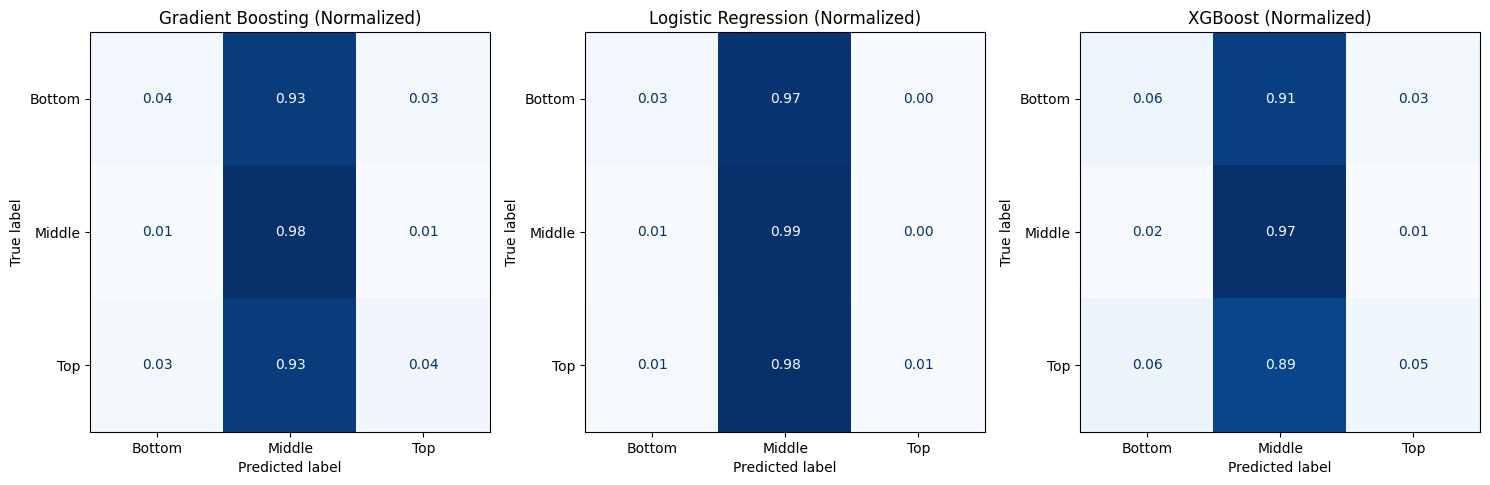

In [ ]:
# STEP 7 — Confusion Matrices (only for selected models)
selected_models = ["XGBoost", "Gradient Boosting", "Logistic Regression"]
filtered_matrices = {k: v for k, v in conf_matrices.items() if k in selected_models}

fig, axes = plt.subplots(1, len(filtered_matrices), figsize=(15, 5))
axes = axes.flatten()

for idx, (name, cm) in enumerate(filtered_matrices.items()):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Bottom", "Middle", "Top"]
    )
    disp.plot(ax=axes[idx], cmap="Blues", values_format=".2f", colorbar=False)
    axes[idx].set_title(f"{name} (Normalized)", fontsize=12)
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

# Performance Metrics

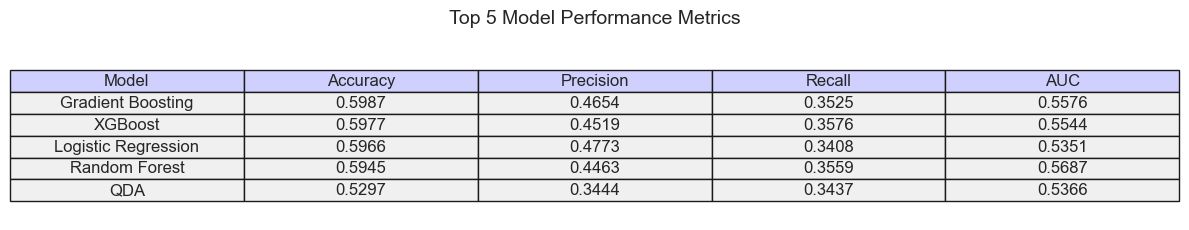

In [ ]:
# STEP 6b — Display Top 5 Model Metrics in a Styled Table
top5_df = metrics_df.head(5).reset_index(drop=True)

plt.figure(figsize=(12, 2.5))
sns.set(font_scale=1.1)
table_plot = plt.table(
    cellText=top5_df[["Model", "Accuracy", "Precision", "Recall", "AUC"]].values,
    colLabels=["Model", "Accuracy", "Precision", "Recall", "AUC"],
    cellLoc="center",
    loc="center",
    cellColours=[["#f0f0f0"] * 5] * 5,
    colColours=["#d0d0ff"] * 5,
)
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(12)
table_plot.scale(1.2, 1.5)
plt.axis("off")
plt.title("Top 5 Model Performance Metrics", fontsize=14, pad=20)
plt.tight_layout()
plt.show()